In [1]:
from __future__ import division
import matplotlib
from pylab import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import math
import h5py

In [2]:
fontSize=16
#matplotlib.rcParams.update({"axes.formatter.limits": (-4,4), "svg.fonttype" : "none", 'font.family':'MathJax_SansSerif', 'font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,'text.usetex':False,'text.latex.preamble':[r'\usepackage{sansmath}',r'\sansmath']})
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4), "svg.fonttype" : "none", 'pdf.fonttype':42,'font.family':'DejaVu Sans','font.sans-serif':'Helvetica','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,'text.usetex':False,'text.latex.preamble':[r'\usepackage{sansmath}',r'\sansmath']})
plotStyles={"markersize":8,"markeredgewidth":1.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
barStyles={"width":0.65, "linewidth":0, "align":"center"}

/Users/turtle/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


## test

In [ ]:
RNAP_1 = np.array([1,0,1,1,1])
m = fill_the_matrix(RNAP_1);
print(m)
m_sub = m[:,1:]
tmp = np.where(m_sub==1)[0]*100 + np.where(m_sub==1)[1]
#print(tmp);
p = 0.5
idx = np.where(np.random.rand(len(tmp))<p)[0];
for jj in tmp[idx]:
    #real index
    row_i = int(floor(jj/100)); 
    col_i = int(jj % 100); 
    m_sub[row_i, col_i] = -1; 

m_new = np.copy(m); 
m_new[:,1:] = m_sub;
print(m_new)


In [ ]:
RNAP_1 = np.array([1,0,1,1,1])

m = fill_the_matrix(RNAP_1);
print(m)
m[2,2] = -1; 
m[3,2] = -1;
print(m)

delta_S1 = 2; 
delta_S2 = 1; 
RNAP_2 = np.array([1,1,1,1,1])
m2 = fill_the_matrix(RNAP_2);
print(m2)

non_zero_index1 = np.where(RNAP_1>0)[0];
non_zero_index2 = np.where(RNAP_2>0)[0];
#corr = {}
for i in range(1,len(non_zero_index2)+1): #cardinarity, from 1,2, to len
    if i <= delta_S1:
        next; # new transcript
    else: 
        current_index = non_zero_index2[i-1]; #zero-based, i = 4, i-1 = 3, current_index = non_zero_index2[3] = 4; 
        previous_index = non_zero_index1[i-delta_S1-1]; #zero-based, i-1-delta_S1 = 1, previous_index = non_zero_index1[1] = 2; 
        m2[current_index, range(current_index+1-previous_index,current_index+1)] = m[previous_index, range(1,previous_index+1)];
print(m2)

## define functions

In [ ]:
def apply_photobleaching(m_, p):
    m_sub = m_[:,1:]
    # encode them
    tmp = np.where(m_sub==1)[0]*100 + np.where(m_sub==1)[1]; 
    
    # photobleach
    idx = np.where(np.random.rand(len(tmp))<p)[0];
    
    # decode them
    for jj in tmp[idx]:
        row_i = int(floor(jj/100)); 
        col_i = int(jj % 100);
        m_sub[row_i, col_i] = -1; 
    
    m_new = np.copy(m_); 
    m_new[:,1:] = m_sub; 
    return m_new

In [283]:
def fill_the_matrix(RNAP_all):
    m = np.zeros((len(RNAP_all), len(RNAP_all))); #row: transcript; col: flurophore
    non_zero_index = np.where(RNAP_all>0)[0];
    for RNAP_i in non_zero_index:     #0 
        m[RNAP_i,range(0,RNAP_i+1)] = 1; 
    return m

def fill_the_matrix2(RNAP_pre, RNAP_current, delta_S1, m1, n_photobleaching):
    m2 = fill_the_matrix(RNAP_current); 
    non_zero_index1 = np.where(RNAP_pre>0)[0];
    non_zero_index2 = np.where(RNAP_current>0)[0];
    
    for ii in range(1,len(non_zero_index2)+1): #cardinarity, from 1,2, to len
        current_index = non_zero_index2[ii-1]; #zero-based
        
        if ii <= delta_S1: 
            # new transcript
            tmp0 = m2[current_index, range(1,current_index+1)]; 
            idx = np.where(np.random.rand(len(tmp0))< 1-(1-p)**n_photobleaching)[0]; 
            tmp0[idx] = -1;
            m2[current_index, range(1,current_index+1)] = tmp0; 
        else: 
            previous_index = non_zero_index1[ii-delta_S1-1]; #zero-based, i-1-delta_S1 = 1, previous_index = non_zero_index1[1] = 2; 

            # new transcript
            tmp0 = m2[current_index, range(1,current_index+1-previous_index)]; 
            idx = np.where(np.random.rand(len(tmp0))< 1-(1-p)**n_photobleaching)[0]; 
            tmp0[idx] = -1;
            m2[current_index, range(1,current_index+1-previous_index)] = tmp0; 
            
            # previous
            m2[current_index, range(current_index+1-previous_index,current_index+1)] = m1[previous_index, range(1,previous_index+1)];
    return m2

In [304]:
filename='3endbinding/noSC_3end.0.19.60.20.lm'; 
replicate_i = 1; 
fp = h5py.File(filename, "r");
times=fp["/Simulations/%07d/SpeciesCountTimes"%replicate_i];
#count = fp["/Simulations/%07d/SpeciesCounts"%replicate_i]; 
len(times)

301

In [305]:
p = 0.05; 

num = 20; 
time = 101;
intens = np.array([]);
time_arr = np.array([]); 
n_photobleaching = 0; 

S1_pre = None; 
S2_pre = None; 
S3_pre = None; 
while time < 301:
    count = fp["/Simulations/%07d/SpeciesCounts"%replicate_i][time,:]; 
    # RNAP_all = count[range(num,2*num)] + count[range(2*num,3*num)]; 
    # mRNA_all = sum(count[range(4*num,5*num)])
    # A = np.sum(np.where(RNAP_all>0)[0]); print(A==mRNA_all); #check 
    
    if S1_pre == None:
        S1_pre = count[7*num+1]; 
        S2_pre = count[7*num+2];
        RNAP_pre = count[range(num,2*num)] + count[range(2*num,3*num)]; 
        
        m_pre = fill_the_matrix(RNAP_pre);
        # apply the photobleaching (1 -> -1)
        
        m_pre = apply_photobleaching(m_pre,p); 
        n_photobleaching = n_photobleaching+1; 
    else:
        S1_current = count[7*num+1]; 
        S2_current = count[7*num+2];
        RNAP_current = count[range(num,2*num)] + count[range(2*num,3*num)]; 
        
        delta_S1 = S1_current - S1_pre; # number of new initiation 
        delta_S2 = S2_current - S2_pre; # number of new termination
        # B = sum(RNAP_pre) + delta_S1 - delta_S2; print(B==sum(RNAP_current)); #check 

        # apply the matching
        m_current = fill_the_matrix2(RNAP_pre, RNAP_current, delta_S1, m_pre, n_photobleaching); 
        
        # apply the photobleaching
        m_current = apply_photobleaching(m_current,p); 
        n_photobleaching = n_photobleaching+1; 
        
        # update
        RNAP_pre = np.copy(RNAP_current);
        S1_pre = S1_current;
        S2_pre = S2_current; 
        m_pre = np.copy(m_current); 
    
    # get the fluorescence intensity over time:
    m_sub = m_pre[:,1:]; 
    intens = np.append(intens, len(np.where(m_sub==1)[0]));
    time_arr = np.append(time_arr, time)
    
    time = time + 5; 

Text(0.5, 1.0, 'one replicate')

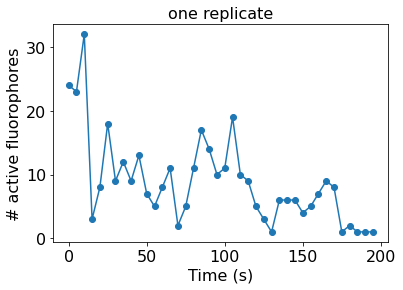

In [306]:
plt.plot(time_arr-time_arr[0], intens,'o-')
plt.xlabel('Time (s)')
plt.ylabel('# active fluorophores')
plt.title('one replicate')

In [317]:
a = np.empty((0,2))
a = np.vstack((a, [1,1]))
print(a)

[[1. 1.]]


In [331]:
p = 0.05; 
num = 20; 

filename='3endbinding/noSC_3end.0.19.60.20.lm'; 
fp = h5py.File(filename, "r");
times=fp["/Simulations/%07d/SpeciesCountTimes"%replicate_i];
intens_all = np.empty((0,40));
time_all = np.empty((0,40));
for replicate_i in range(1,101):
    
    time = 101;
    intens = np.array([]);
    time_arr = np.array([]); 
    n_photobleaching = 0; 
    
    S1_pre = None; 
    S2_pre = None; 
    while time < 301:
        count = fp["/Simulations/%07d/SpeciesCounts"%replicate_i][time,:]; 
        if S1_pre == None:
            S1_pre = count[7*num+1]; 
            S2_pre = count[7*num+2];
            RNAP_pre = count[range(num,2*num)] + count[range(2*num,3*num)]; 
            
            m_pre = fill_the_matrix(RNAP_pre);
            # apply the photobleaching (1 -> -1)
            
            m_pre = apply_photobleaching(m_pre,p); 
            n_photobleaching = n_photobleaching+1; 
        else:
            S1_current = count[7*num+1]; 
            S2_current = count[7*num+2];
            RNAP_current = count[range(num,2*num)] + count[range(2*num,3*num)]; 
            
            delta_S1 = S1_current - S1_pre; # number of new initiation 
            delta_S2 = S2_current - S2_pre; # number of new termination
            
            # apply the matching
            m_current = fill_the_matrix2(RNAP_pre, RNAP_current, delta_S1, m_pre, n_photobleaching); 
            
            # apply the photobleaching
            m_current = apply_photobleaching(m_current,p); 
            n_photobleaching = n_photobleaching+1; 
            
            # update
            RNAP_pre = np.copy(RNAP_current);
            S1_pre = S1_current;
            S2_pre = S2_current; 
            m_pre = np.copy(m_current); 
        
        # get the fluorescence intensity over time:
        m_sub = m_pre[:,1:]; 
        intens = np.append(intens, len(np.where(m_sub==1)[0]));
        time_arr = np.append(time_arr, time)
    
        time = time + 5; 
    intens_all = np.vstack((intens_all, intens));
    time_all = np.vstack((time_all, time_arr));

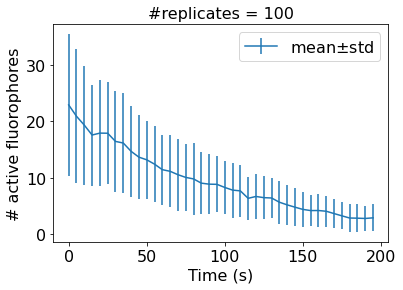

In [333]:
#plt.plot(time_all-time_all[0], intens_all,'o-')
plt.errorbar(np.mean(time_all,axis=0)-np.mean(time_all[:,0]), \
             np.mean(intens_all, axis=0), yerr=np.std(intens_all,axis=0), \
            label='mean$\pm$std')
plt.xlabel('Time (s)')
plt.ylabel('# active fluorophores')
plt.title('#replicates = 100')
plt.legend()

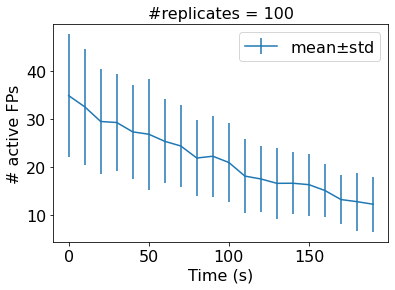

In [381]:
p = 0.05; 
num = 20; 

filename='3endbinding/noSC_3end.0.19.30.20.lm'; 
fp = h5py.File(filename, "r");
times=fp["/Simulations/%07d/SpeciesCountTimes"%replicate_i];
intens_all = np.empty((0,20));
time_all = np.empty((0,20));
for replicate_i in range(1,101):
    
    time = 101;
    intens = np.array([]);
    time_arr = np.array([]); 
    n_photobleaching = 0; 
    
    S1_pre = None; 
    S2_pre = None; 
    while time < 301:
        count = fp["/Simulations/%07d/SpeciesCounts"%replicate_i][time,:]; 
        if S1_pre == None:
            S1_pre = count[7*num+1]; 
            S2_pre = count[7*num+2];
            RNAP_pre = count[range(num,2*num)] + count[range(2*num,3*num)]; 
            
            m_pre = fill_the_matrix(RNAP_pre);
            # apply the photobleaching (1 -> -1)
            
            m_pre = apply_photobleaching(m_pre,p); 
            n_photobleaching = n_photobleaching+1; 
        else:
            S1_current = count[7*num+1]; 
            S2_current = count[7*num+2];
            RNAP_current = count[range(num,2*num)] + count[range(2*num,3*num)]; 
            
            delta_S1 = S1_current - S1_pre; # number of new initiation 
            delta_S2 = S2_current - S2_pre; # number of new termination
            
            # apply the matching
            m_current = fill_the_matrix2(RNAP_pre, RNAP_current, delta_S1, m_pre, n_photobleaching); 
            
            # apply the photobleaching
            m_current = apply_photobleaching(m_current,p); 
            n_photobleaching = n_photobleaching+1; 
            
            # update
            RNAP_pre = np.copy(RNAP_current);
            S1_pre = S1_current;
            S2_pre = S2_current; 
            m_pre = np.copy(m_current); 
        
        # get the fluorescence intensity over time:
        m_sub = m_pre[:,1:]; 
        intens = np.append(intens, len(np.where(m_sub==1)[0]));
        time_arr = np.append(time_arr, time)
    
        time = time + 10; 
    intens_all = np.vstack((intens_all, intens));
    time_all = np.vstack((time_all, time_arr));

plt.rcParams["figure.figsize"] = (6,4)
plt.errorbar(np.mean(time_all,axis=0)-np.mean(time_all[:,0]), \
             np.mean(intens_all, axis=0), yerr=np.std(intens_all,axis=0), \
            label='mean$\pm$std')
plt.xlabel('Time (s)')
plt.ylabel('# active FPs')
plt.title('#replicates = 100')
plt.legend()

### individual replicate

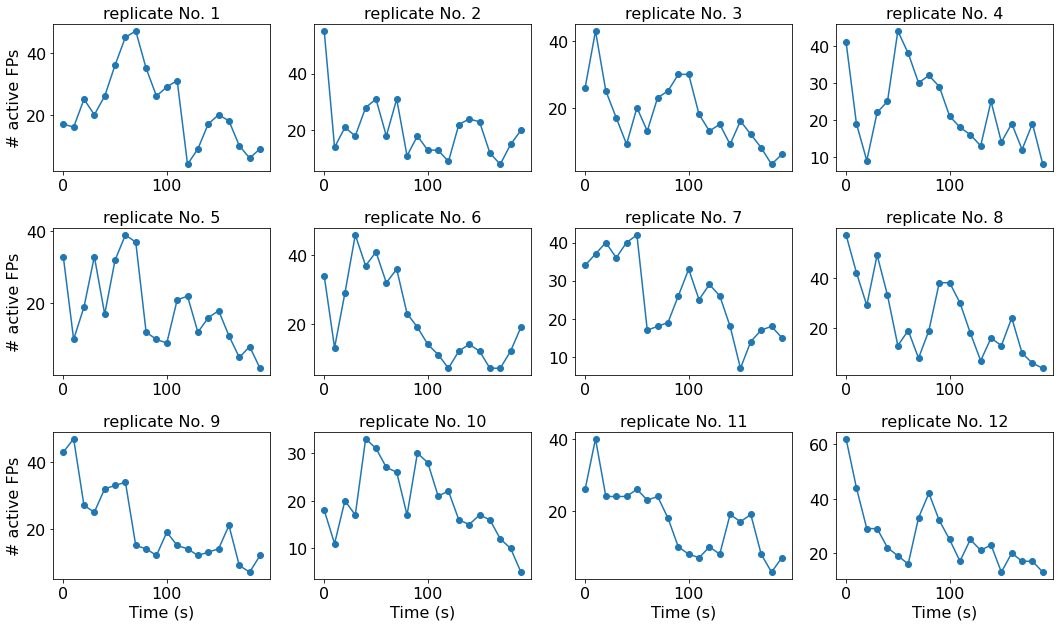

In [382]:
#plt.axhline(0, color='tab:red')
plt.rcParams["figure.figsize"] = (15,9)
for i in range(1,13):
    subplot(3,4,i)
    plt.plot(time_all[i-1,:]-time_all[i-1,0], intens_all[i-1,:], 'o-'); 
    if i in [1,5,9]:
        plt.ylabel('# active FPs')
    if i in [9,10,11,12]:
        plt.xlabel('Time (s)')
    plt.title('replicate No. '+str(i))
plt.tight_layout()

In [383]:
### autocorrelation

def cal_autocorr(counts, tau, len_replicate, duration):
    numerator = np.array([]);
    F_i = np.mean(counts[:,0:duration], axis=0);
    for i in range(0, len_replicate):
        n_tmp = counts[i,0:duration-tau]*counts[i,tau:]; #0,1,...,duration-tau-1 ==> 1,2,...,duration - tau
        numerator = np.append(numerator, n_tmp); #tau, tau+1, ..., duration - 1 ==> tau+1, tau+2, ..., duration
    return np.mean(numerator)/(np.mean(F_i)*np.mean(F_i))-1

duration = len(intens_all[0,:]); 
autocorr = np.zeros(duration);
for tau in range(0,duration):
    autocorr[tau] = cal_autocorr(intens_all, tau, 100,duration);
    

In [384]:
from scipy.optimize import curve_fit
import decimal

def term1(tau,N,c,k,denom):
    S = 0;
    for n in range(0,N+1):
        S += (N-n)*(N-n+1)*(2*N+n+1)/6*(k*tau)**n/np.math.factorial(n); 
    return S*c/k*np.exp(-k*tau)/denom

def denominator(N,c,k):
    return (c/k)**2*(N*(N+1)/2)**2

decimal.getcontext().prec = 100

term1 = np.vectorize(term1)

def my_func(tau,c,k):
    S = 0;
    denom = (c/k)**2*(N*(N+1)/2)**2; 
    for n in range(0,N+1):
        S = S+(N-n)*(N-n+1)*(2*N+n+1)/6*(k*tau)**n/np.math.factorial(n);
    return S*c/k*np.exp(-k*tau)/denom

my_func = np.vectorize(my_func)

Text(0.5, 1.0, '#replicates = 100')

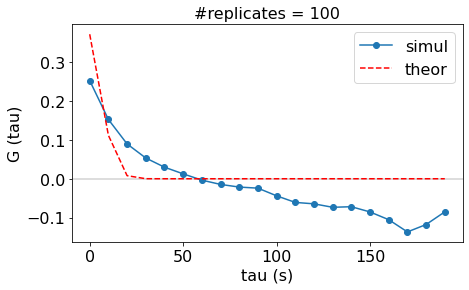

In [386]:
tau = np.arange(0,duration)*10; 
n_elong = 60; whole_len = 19*58;
N = 19; c = 0.19; single_loop = whole_len/N; k = n_elong/single_loop;
plt.rcParams["figure.figsize"] = (7,4)
plt.axhline(0, color='lightgrey')
plt.plot(tau, autocorr, 'o-',label='simul')
plt.plot(tau, term1(tau,N,c,k,denominator(N,c,k)), 'r--', label='theor');
plt.ylabel('G (tau)')
plt.xlabel('tau (s)')
plt.legend()
plt.title('#replicates = 100')